In [1]:
import os
import sys

sys.path.append(os.path.realpath('..'))

import google.auth


import pandas as pd
pd.options.display.max_colwidth = 100

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

def keth(x, pos):
    'The two args are the value and tick position'
    return '%1.fK' % (x * 1e-3)
keth_formatter = FuncFormatter(keth)

import pandas_gbq
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file('/Users/ankitchiplunkar/.config/gcloud/.gcloud.json')
pandas_gbq.context.project = 'frontier0x'
pandas_gbq.context.credentials = credentials

### Gas price by index

In [2]:
df = pd.read_gbq("""
select transaction_index, -- DATE(block_timestamp) as dinank, 
avg(effective_gas_price) as effective_gas_price, avg(egp.receipt_effective_gas_price-base_fee_per_gas) as priority_gas_price, 
avg(effective_gas_price - egp.receipt_effective_gas_price) as tip_gas_price
FROM `frontier0x.research.effective_gas_price_q12023` as egp
inner join `bigquery-public-data.crypto_ethereum.transactions` as t
on egp.transaction_hash = t.hash
and DATE(block_timestamp) < "2023-04-01"
and DATE(block_timestamp) >= "2023-01-01"
group by 1 -- , 2
""")




In [3]:
df['effective_gas_price'] = pd.to_numeric(df['effective_gas_price'])
df['tip_gas_price'] = pd.to_numeric(df['tip_gas_price'])

<Axes: title={'center': 'Gas price of miner tip by transaction index'}, xlabel='transaction_index'>

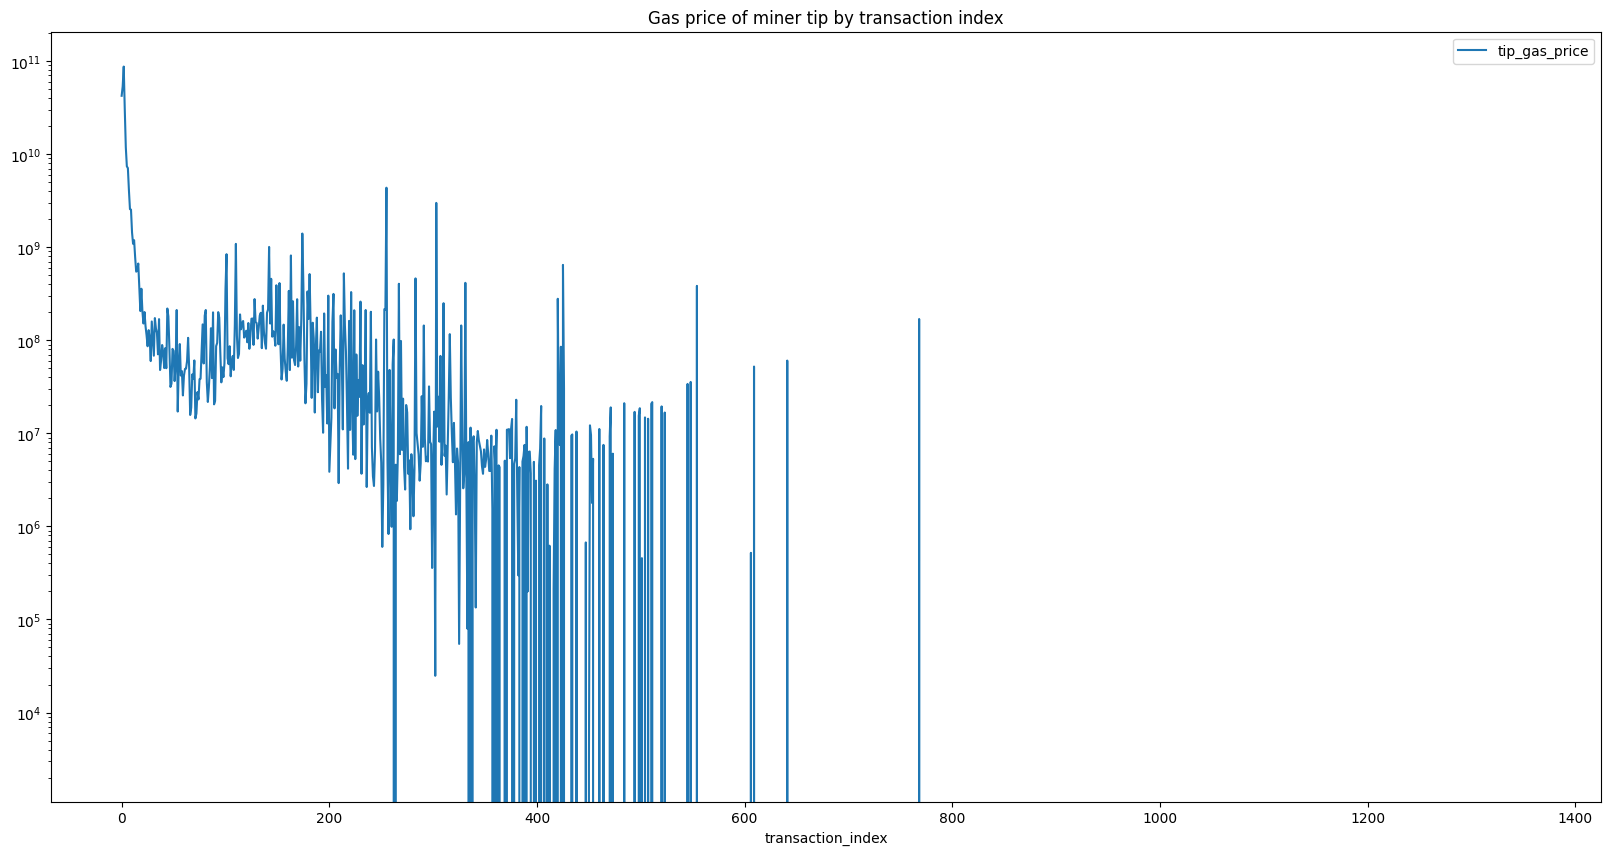

In [4]:
df.sort_values(by='transaction_index', inplace=True)
df.plot(x='transaction_index', y='tip_gas_price', figsize=(20,10), logy=True, title='Gas price of miner tip by transaction index')

<Axes: title={'center': 'Gas price of priority fee by transaction index'}, xlabel='transaction_index'>

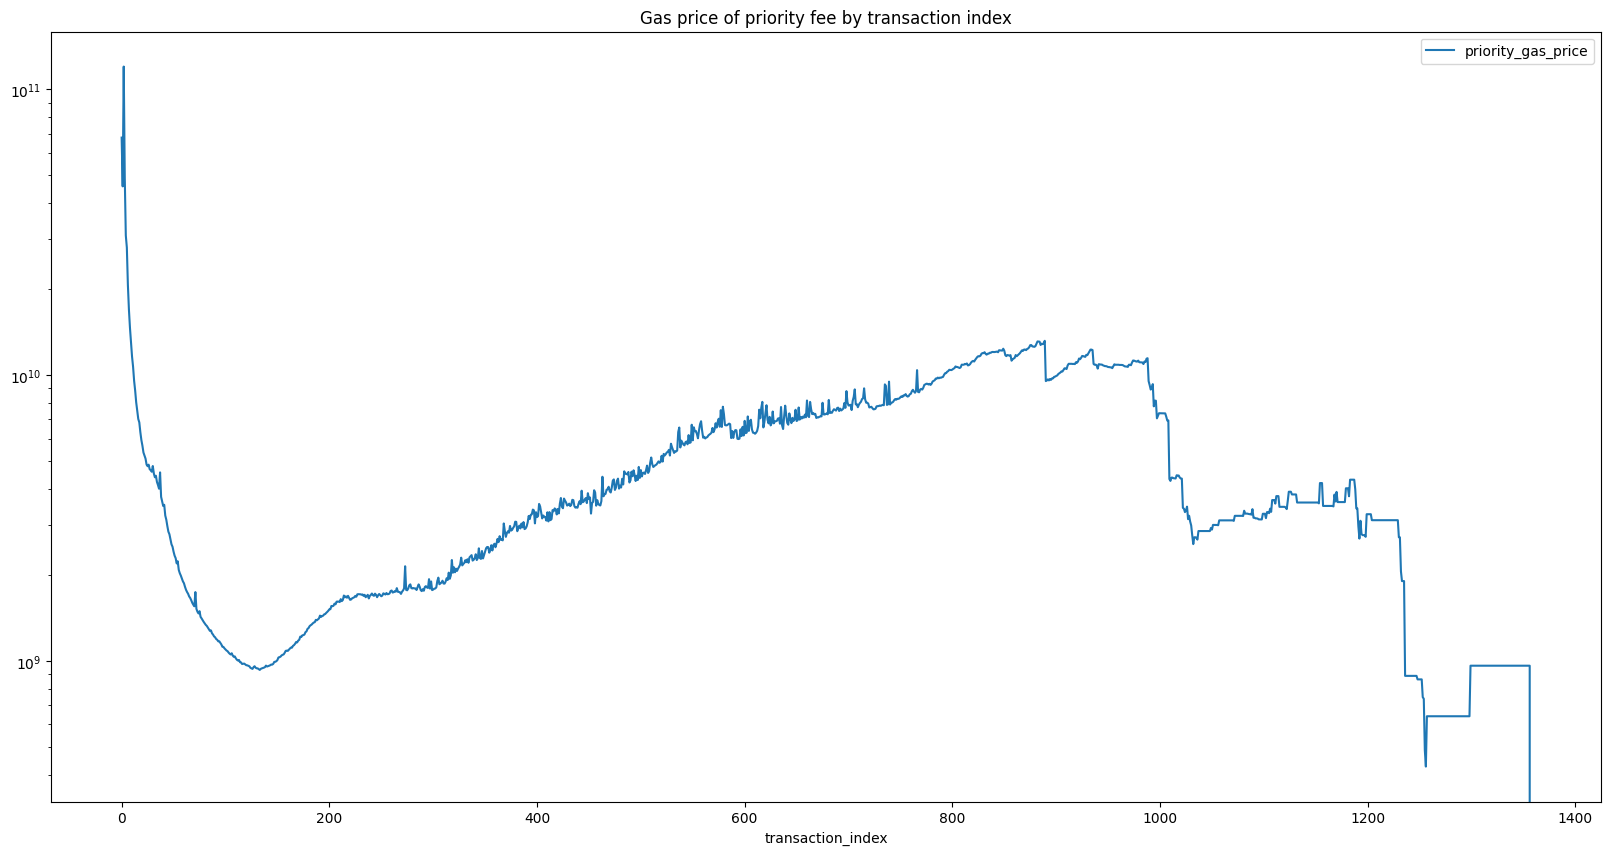

In [5]:
df.plot(x='transaction_index', y='priority_gas_price', figsize=(20,10), logy=True, title='Gas price of priority fee by transaction index')

### AS PERCENTAGE

In [6]:
df2 = pd.read_gbq("""
select floor(transaction_index * 1000 /max_transaction_index)/10 as transaction_index_percentage, count(1) as total_txs,
-- DATE(block_timestamp) as dinank, 
avg(effective_gas_price) as effective_gas_price, avg(receipt_effective_gas_price-base_fee_per_gas) as priority_gas_price, 
avg(effective_gas_price - receipt_effective_gas_price) as tip_gas_price,
avg(effective_gas_price - base_fee_per_gas) as proposer_payment_gas_price,
FROM
(select  effective_gas_price, egp.receipt_effective_gas_price, base_fee_per_gas, transaction_index, MAX(transaction_index) OVER (PARTITION BY egp.block_number) as max_transaction_index 
FROM `frontier0x.research.effective_gas_price_q12023` as egp
inner join `bigquery-public-data.crypto_ethereum.transactions` as t
on egp.transaction_hash = t.hash
and DATE(block_timestamp) < "2023-04-01"
and DATE(block_timestamp) >= "2023-01-01"
AND t.to_address != '0xb0bababe78a9be0810fadf99dd2ed31ed12568be' )
WHERE max_transaction_index > 0
group by 1 -- , 2
limit 1000
""")

In [7]:
df2[df2['transaction_index_percentage'] > 98].sort_values(by='transaction_index_percentage', ascending=False)

,transaction_index_percentage,total_txs,effective_gas_price,priority_gas_price,tip_gas_price,proposer_payment_gas_price
950,100.0,634823,25515098794.665210727,4.373750e+07,230566024.829650264,274303525.674077766
765,99.8,1270,39779143262.025984252,2.460395e+09,0E-9,2460394697.428346457
262,99.7,8701,30232904694.271653081,1.045092e+09,96505129.626324958,1141597219.322336911
258,99.6,26757,27787481083.662314263,9.816517e+08,42941483.350844367,1024593219.196679102
999,99.5,40859,27658868699.570415766,5.255007e+08,11008468.147913992,536509190.621860980
690,99.4,81899,27842841293.379447197,3.609578e+08,17676201.736850828,378633998.099016423
246,99.3,145248,27066939540.140814405,3.010822e+08,78114559.268602739,379196748.271556308
995,99.2,156580,25747047709.126981456,3.298969e+08,11505770.615019520,341402632.132212009
74,99.1,110094,25024479099.980149403,3.642830e+08,45031329.409064693,409314311.035093360
97,99.0,85698,24859468100.013365194,3.858292e+08,11350639.528348041,397179793.238644664


In [8]:
df2['effective_gas_price'] = pd.to_numeric(df2['effective_gas_price'])
df2['priority_gas_price'] = pd.to_numeric(df2['priority_gas_price'])
df2['tip_gas_price'] = pd.to_numeric(df2['tip_gas_price'])
df2['proposer_payment_gas_price'] = pd.to_numeric(df2['proposer_payment_gas_price'])
df2[df2['transaction_index_percentage'] > 98].sort_values(by='transaction_index_percentage', ascending=False)

,transaction_index_percentage,total_txs,effective_gas_price,priority_gas_price,tip_gas_price,proposer_payment_gas_price
950,100.0,634823,2.551510e+10,4.373750e+07,2.305660e+08,2.743035e+08
765,99.8,1270,3.977914e+10,2.460395e+09,0.000000e+00,2.460395e+09
262,99.7,8701,3.023290e+10,1.045092e+09,9.650513e+07,1.141597e+09
258,99.6,26757,2.778748e+10,9.816517e+08,4.294148e+07,1.024593e+09
999,99.5,40859,2.765887e+10,5.255007e+08,1.100847e+07,5.365092e+08
690,99.4,81899,2.784284e+10,3.609578e+08,1.767620e+07,3.786340e+08
246,99.3,145248,2.706694e+10,3.010822e+08,7.811456e+07,3.791967e+08
995,99.2,156580,2.574705e+10,3.298969e+08,1.150577e+07,3.414026e+08
74,99.1,110094,2.502448e+10,3.642830e+08,4.503133e+07,4.093143e+08
97,99.0,85698,2.485947e+10,3.858292e+08,1.135064e+07,3.971798e+08


<Axes: title={'center': 'Gas price of proposer_payment_gas_price by transaction index'}, xlabel='transaction_index_percentage'>

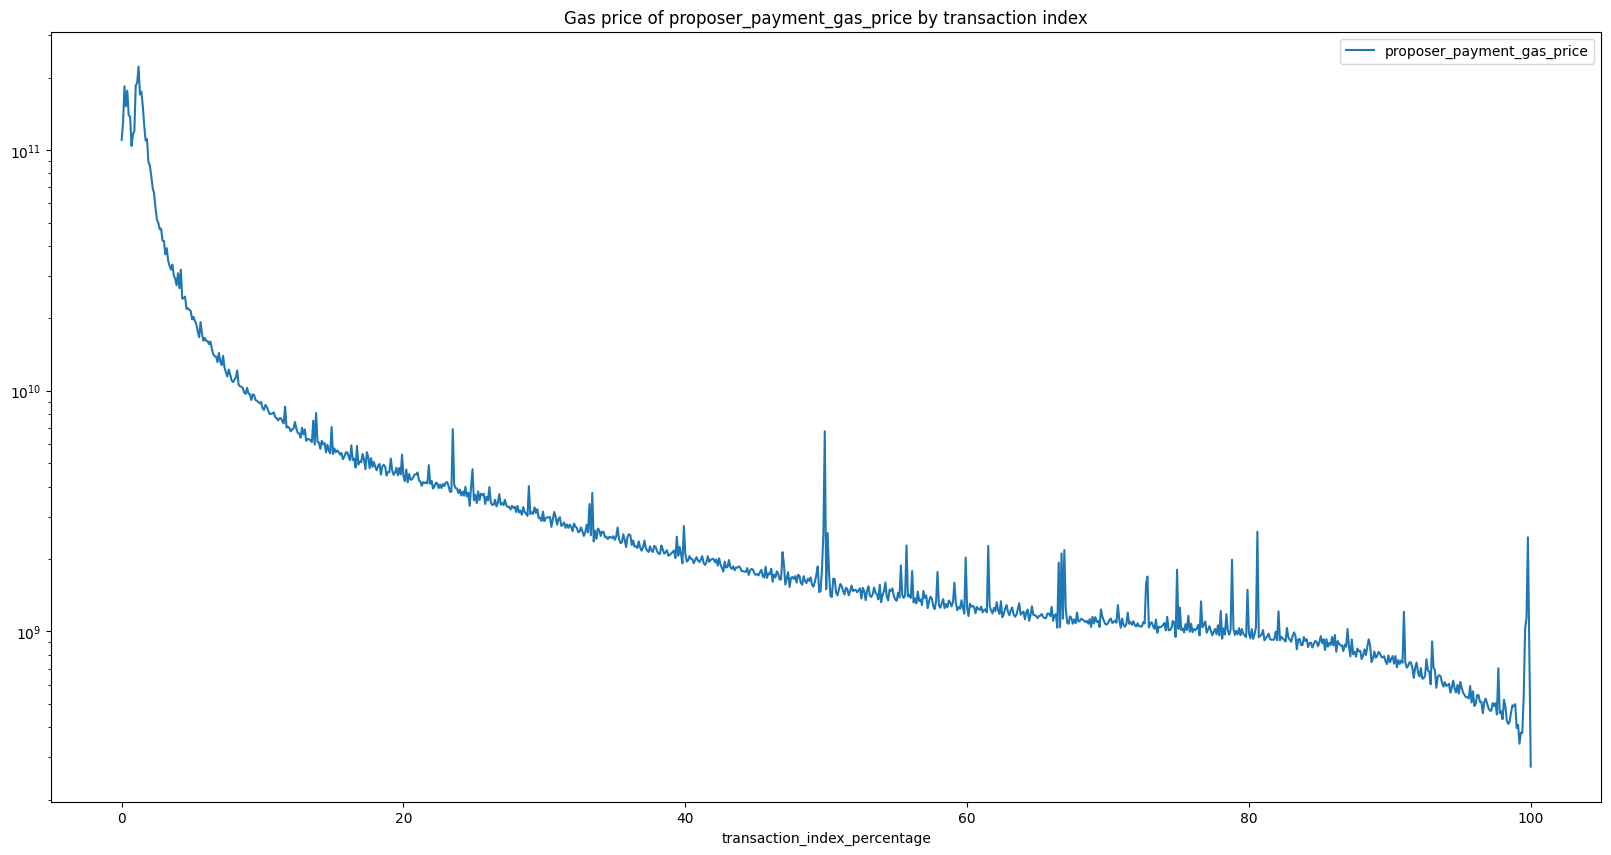

In [9]:
df2.sort_values(by='transaction_index_percentage', inplace=True)
df2.plot(x='transaction_index_percentage', y='proposer_payment_gas_price', figsize=(20,10), logy=True, title='Gas price of proposer_payment_gas_price by transaction index')

<Axes: title={'center': 'Gas price of priority_gas_price by transaction index'}, xlabel='transaction_index_percentage'>

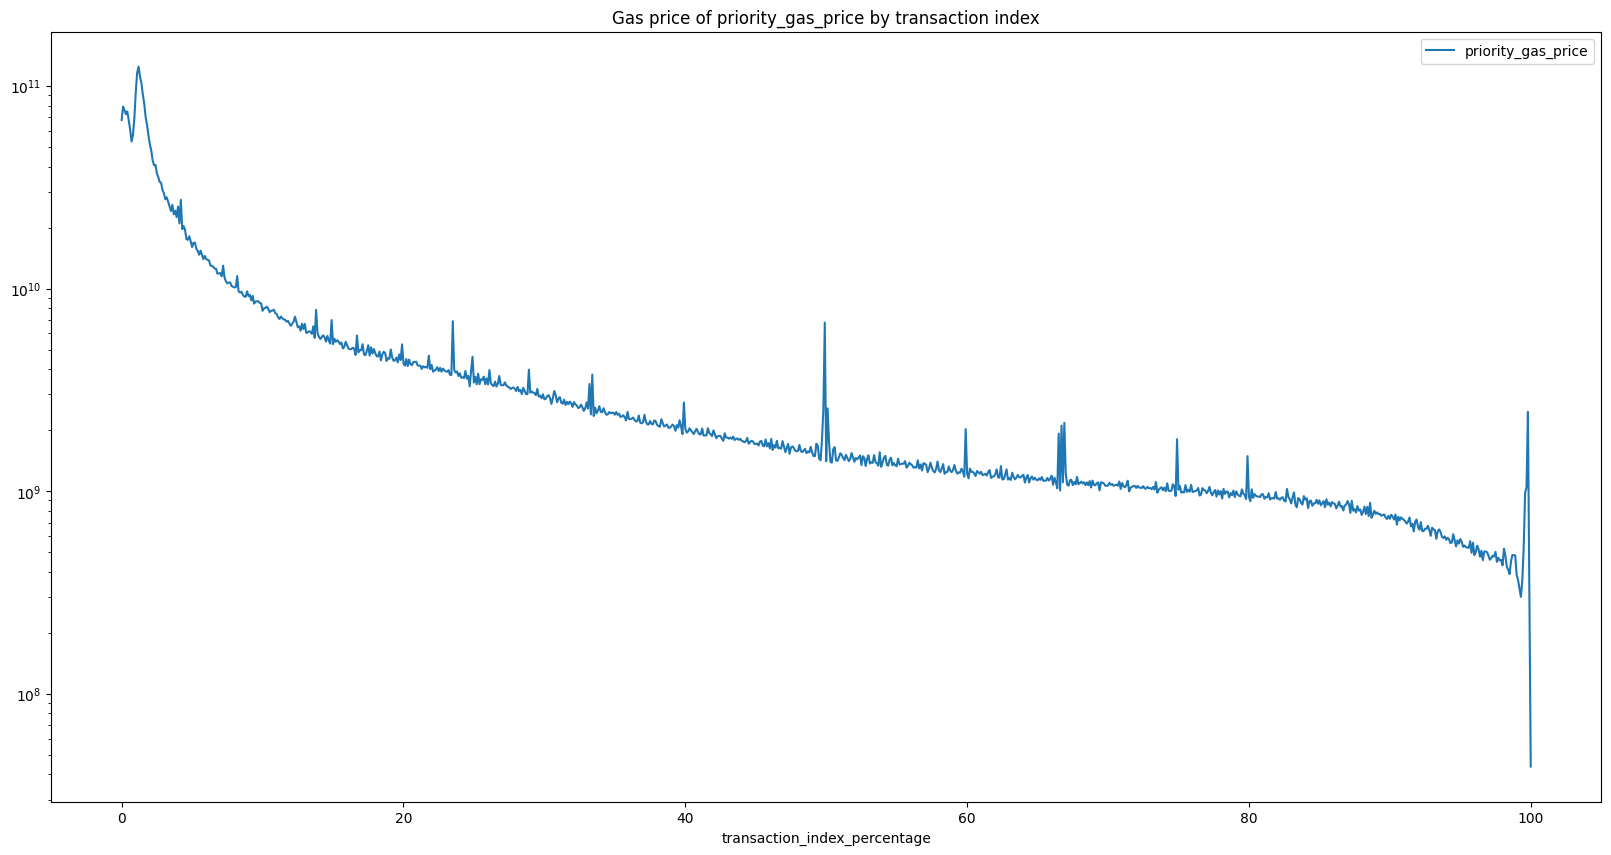

In [10]:
df2.plot(x='transaction_index_percentage', y='priority_gas_price', figsize=(20,10), logy=True, title='Gas price of priority_gas_price by transaction index')

<Axes: title={'center': 'Gas price of tip_gas_price by transaction index'}, xlabel='transaction_index_percentage'>

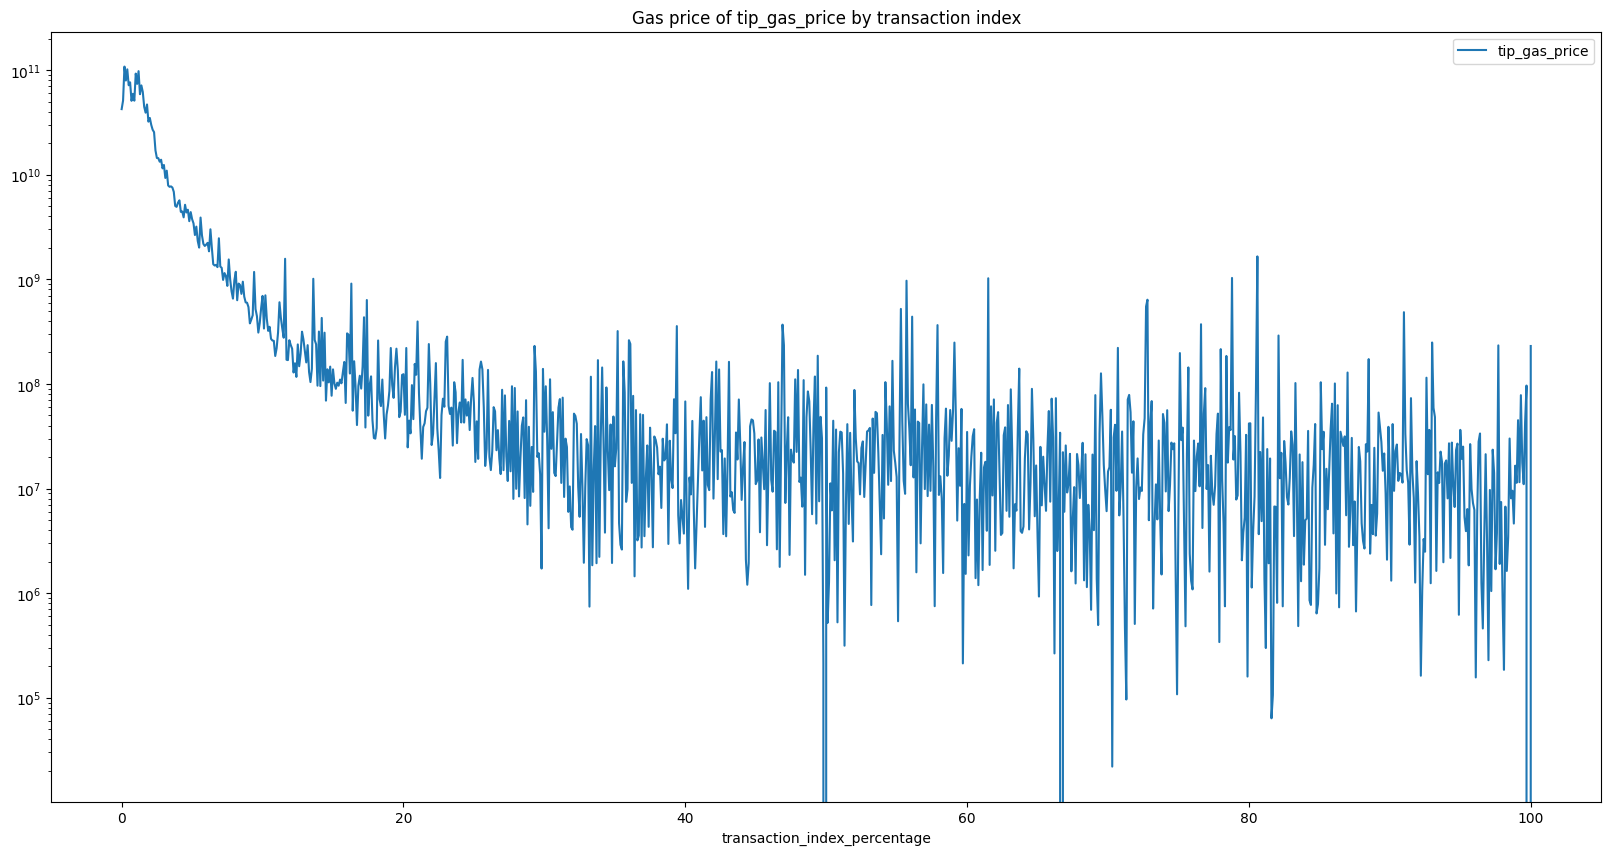

In [11]:
df2.plot(x='transaction_index_percentage', y='tip_gas_price', figsize=(20,10), logy=True, title='Gas price of tip_gas_price by transaction index')

<Axes: title={'center': 'Effective gas price by transaction index'}, xlabel='transaction_index'>

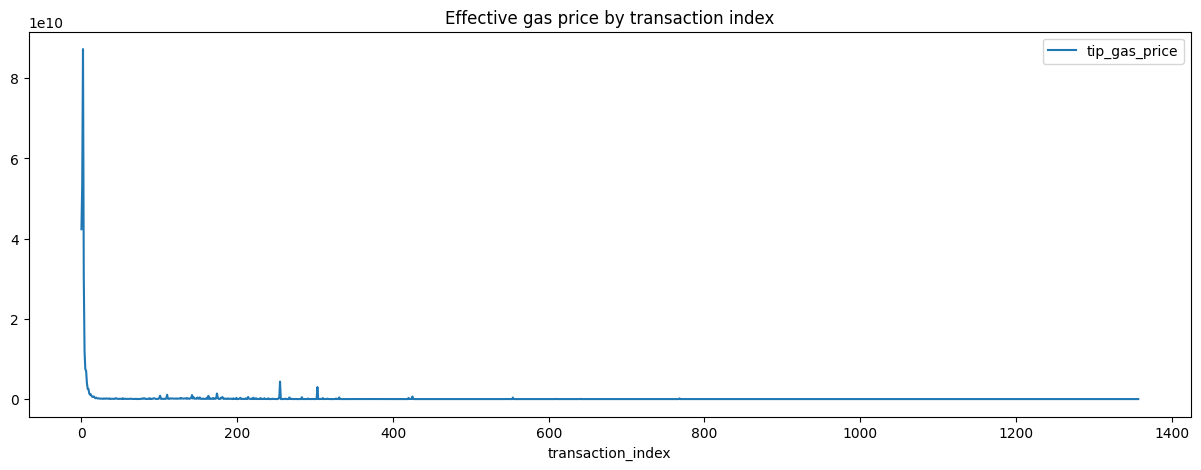

In [12]:
df.set_index('transaction_index').plot(y='tip_gas_price', figsize=(15, 5), title='Effective gas price by transaction index')